In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

from utilities2014 import *

import time

sys.path.append('/home/yuncong/project/opencv-2.4.9/release/lib/python2.7/site-packages')
import cv2

from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import average, fcluster, leaders, complete, single, dendrogram, ward

from joblib import Parallel, delayed

from skimage.color import gray2rgb
from skimage.util import img_as_float, pad
from skimage.morphology import disk
from skimage.filters.rank import gradient

from collections import defaultdict, Counter
from itertools import combinations, chain, product

import networkx
from networkx import from_dict_of_lists, dfs_postorder_nodes

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
from scipy.interpolate import RectBivariateSpline
from skimage.feature import peak_local_max

import cPickle as pickle

In [3]:
# dms = [DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=i) for i in range(7)]

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [14]:
from enum import Enum

class PolygonType(Enum):
    CLOSED = 'closed'
    OPEN = 'open'
    TEXTURE = 'textured'
    TEXTURE_WITH_CONTOUR = 'texture with contour'
    DIRECTION = 'directionality'

In [2]:
section_ind = 5

dm = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=5)
dm._load_image()

texton_hists = dm.load_pipeline_result('texHist', 'npy')
segmentation = dm.load_pipeline_result('segmentation', 'npy')
n_superpixels = len(np.unique(segmentation)) - 1
textonmap = dm.load_pipeline_result('texMap', 'npy')
n_texton = len(np.unique(textonmap)) - 1

texture_map = dm.load_pipeline_result('textureMap', 'npy')
Gmax = dm.load_pipeline_result('Gmax', 'npy')

# alpha = 1.5
# Gmax = 1 - 1/(1+alpha*Gmax)

Gthresh = 1.
beta = 5.
Gmax = 1/(1+np.exp(-beta*(Gmax-Gthresh)))
# x = np.linspace(0,1.9,100)
# plt.plot(x, 1/(1+np.exp(-beta*(x-Gthresh))))

coherence_map = dm.load_pipeline_result('coherenceMap', 'npy')
eigenvec_map = dm.load_pipeline_result('eigenvecMap', 'npy')

thetas = np.linspace(-np.pi/4, np.pi/4, 9)
n_theta = len(thetas)
Rs = [np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]) for theta in thetas]

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [3]:
grid_spacing = (10,10)

In [5]:
n_boundary_texture_sample = 5
boundary_texture_sample_pos = np.linspace(0,1,n_boundary_texture_sample) * 20

In [24]:
def evaluate_spline_partial(spline, s):
    return spline(s, range(dm.image_height)) # indirect call is faster than directly put spline() in delayed; don't know why


def compute_filter_response_at_points(pts, has_boundary, has_texture, has_striation):
    
    n = len(pts)
    
    vs = np.empty((n,), dtype=np.float)
    vs_texture = np.empty((n,), dtype=np.float)
    vs_boundary = np.empty((n,), dtype=np.float)
    vs_striation = np.empty((n,), dtype=np.float)

    for i, (x, y) in enumerate(pts):

        if not has_texture:
            v_texture = np.nan
        else:
            bbox_ymax_global = y + template_height - 1 - centroid_local_y
            bbox_ymin_global = y - centroid_local_y
            bbox_xmax_global = x + template_width - 1 - centroid_local_x
            bbox_xmin_global = x - centroid_local_x

            texture_img = texture_map[bbox_ymin_global:bbox_ymax_global+1:10, 
                             bbox_xmin_global:bbox_xmax_global+1:10].reshape((-1,n_texton))

            chi2_dists = chi2s(texture_img, texture_template)

            # I expect to see RuntimeWarnings in this block
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                v_texture = np.nansum(np.exp(-chi2_dists/.5)) / len(chi2_dists)
                if np.isnan(v_texture):
                    v_texture = 0
                    
        if not has_boundary:
            v_boundary = np.nan
        else:
            vertices_global_ys = (boundary_vertices[:,1] + y - centroid_local_y).astype(np.int, copy=False)
            vertices_global_xs = (boundary_vertices[:,0] + x - centroid_local_x).astype(np.int, copy=False)

            try:
                r = Gmax[vertices_global_ys, vertices_global_xs]
            except Exception as e:
                print x, y, vertices_global_xs.max(axis=0), vertices_global_ys.max(axis=0), Gmax.shape
                raise e

            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                
                int_xs = np.maximum(np.minimum(vertices_global_xs[:,None] + int_texture_sampling_positions[:,:,0], 
                                               dm.image_width-1), 0)
                int_ys = np.maximum(np.minimum(vertices_global_ys[:,None] + int_texture_sampling_positions[:,:,1],
                                               dm.image_height-1), 0)
                avg_int_texture = np.nanmean(texture_map[int_ys, int_xs], axis=1)
                int_texture_dists = chi2s(boundary_textures[:,:n_texton], avg_int_texture)

                
                ext_xs = np.maximum(np.minimum(vertices_global_xs[:,None] + ext_texture_sampling_positions[:,:,0],
                                               dm.image_width-1), 0)
                ext_ys = np.maximum(np.minimum(vertices_global_ys[:,None] + ext_texture_sampling_positions[:,:,1], 
                                               dm.image_height-1), 0)
                avg_ext_texture = np.nanmean(texture_map[ext_ys, ext_xs], axis=1)
                ext_texture_dists = chi2s(boundary_textures[:,n_texton:], avg_ext_texture)

                sigma = .5
                v_boundary = np.nansum(r * (np.exp(-int_texture_dists/(2*sigma))
                                            + np.exp(-ext_texture_dists/(2*sigma))))
 
        if not has_striation:
            v_striation = np.nan
        else:
            striation_points_global_ys = (striation_points[:,1] + y - centroid_local_y).astype(np.int, copy=False)
            striation_points_global_xs = (striation_points[:,0] + x - centroid_local_x).astype(np.int, copy=False)
            
            sample_vecs = eigenvec_map[striation_points_global_ys, striation_points_global_xs]
            vec_cosine_sims = np.abs(np.sum(sample_vecs * striation_vecs, axis=1))
            v_striation = np.mean(vec_cosine_sims)
        
        vs_texture[i] = v_texture
        vs_boundary[i] = v_boundary
        vs_striation[i] = v_striation
        vs[i] = 5. * np.nan_to_num(v_texture) + np.nan_to_num(v_boundary) + np.nan_to_num(v_striation)

    return vs, vs_texture, vs_boundary, vs_striation

In [33]:
def filter_image_with_landmark_descriptor(lm_ind):
    
    print 'landmark', lm_ind

    
    global template_height, template_width, centroid_local_y, centroid_local_x
    
    global boundary_vertices
    global boundary_textures
    global ext_texture_sampling_positions
    global int_texture_sampling_positions

    global striation_points
    global striation_vecs
      
    global texture_template
        

    b = time.time()
    with open('/home/yuncong/csd395/landmark_descriptors/RS141_0001_yuncong_08212015001655_landmark_descriptors_%d.pkl'%lm_ind, 'r') as f:
        landmark_descriptor_all_rotations = pickle.load(f)
    print 'load', time.time() - b
       
    vs_max = np.zeros((dm.image_height, dm.image_width))
    vs_argmax = np.zeros((dm.image_height, dm.image_width), np.uint8)

    vs_max_all_angles = []
    vs_texture_all_angles = []
    vs_boundary_all_angles = []
    vs_striation_all_angles = []

    has_boundary = False
    has_texture = False
    has_striation = False
    
    for theta_i in range(n_theta):
        print 'theta', theta_i

        b = time.time()
        
        landmark_descriptor = landmark_descriptor_all_rotations[theta_i]
        
        template_width, template_height, centroid_local_x, centroid_local_y = landmark_descriptor['bbox'][:4]
        
        ys, xs = np.mgrid[centroid_local_y : dm.image_height  - (template_height - centroid_local_y) : grid_spacing[0], 
                          centroid_local_x : dm.image_width - (template_width - centroid_local_x) : grid_spacing[1]]
        
        if 'boundary_normals' in landmark_descriptor and len(landmark_descriptor['boundary_normals']) > 0:
            ext_texture_sampling_positions = (landmark_descriptor['boundary_normals'][:, None] * boundary_texture_sample_pos[None,:,None]).astype(np.int)
            int_texture_sampling_positions = - ext_texture_sampling_positions
            
            boundary_vertices = landmark_descriptor['boundary_vertices_local']
            boundary_textures = np.c_[landmark_descriptor['boundary_int_texture'],
                                      landmark_descriptor['boundary_ext_texture']]
            has_boundary = True
            
        if 'textured_area_template' in landmark_descriptor:
            texture_template = landmark_descriptor['textured_area_template'][::10,::10].reshape((-1,n_texton))
            has_texture = True
            
        if 'striation_points_local' in landmark_descriptor and len(landmark_descriptor['striation_points_local']) > 0:
            striation_points = landmark_descriptor['striation_points_local']
            striation_vecs = landmark_descriptor['striation_vecs']
            has_striation = True
                    
        res =  Parallel(n_jobs=16)(delayed(compute_filter_response_at_points)(s, 
                                          has_boundary, has_texture, has_striation) 
                                   for s in np.array_split(zip(xs.flat, ys.flat), 16))

        vs, vs_texture, vs_boundary, vs_striation = zip(*res)
        
        # V = []
        # for s in np.array_split(zip(xs.flat, ys.flat), 16):
        # #         q = time.time()
        #     V.append(compute_filter_response_at_points(s, theta, t2, template_height, template_width, yc, xc))
        # #         print time.time() - q

        vs = np.reshape(np.concatenate(vs), xs.shape)
        vs_texture = np.reshape(np.concatenate(vs_texture), xs.shape)
        vs_boundary = np.reshape(np.concatenate(vs_boundary), xs.shape)
        vs_striation = np.reshape(np.concatenate(vs_striation), xs.shape)

        vs_texture = vs_texture/np.nanmax(vs_texture)
        vs_boundary = vs_boundary/np.nanmax(vs_boundary)
        vs_striation = vs_striation/np.nanmax(vs_striation)
        vs = np.nan_to_num(vs_texture) + np.nan_to_num(vs_boundary) + np.nan_to_num(vs_striation)
        
        # interpolate over entire image domain
        spline = RectBivariateSpline(range(centroid_local_x, dm.image_width + centroid_local_x - template_width, grid_spacing[1]), 
                                     range(centroid_local_y, dm.image_height + centroid_local_y - template_height, grid_spacing[0]),
                                     vs.T, bbox=[0, dm.image_width-1, 0, dm.image_height-1])

        xmax = xs.max()
        ymax = ys.max()
        xmin = xs.min()
        ymin = ys.min()

        res = Parallel(n_jobs=16)(delayed(evaluate_spline_partial)(spline, s) 
                                  for s in np.array_split(range(dm.image_width), 16))
        vs_i = np.vstack(res).T
        vs_i[~dm.mask] = 0.
        vs_i[ymax+1:dm.image_height] = 0.
        vs_i[:ymin] = 0.
        vs_i[:, xmax+1:dm.image_width] = 0.
        vs_i[:, :xmin] = 0.
                
        vs_i_normalized = vs_i/np.nansum(vs_i)
        
        vs_max_all_angles.append(vs_i_normalized)
        vs_texture_all_angles.append(vs_texture)
        vs_boundary_all_angles.append(vs_boundary)
        vs_striation_all_angles.append(vs_striation)
        
        print time.time() - b

    dm.save_pipeline_result(np.asarray(vs_max_all_angles), 'responseMapLmAllRotations%d'%lm_ind, 'npy')
    
    return vs_max_all_angles, vs_texture_all_angles, vs_boundary_all_angles, vs_striation_all_angles

In [34]:
landmark_indices = range(17)
for lm_ind in landmark_indices:
    _ = filter_image_with_landmark_descriptor(lm_ind)

landmark 0
load 41.0311119556
theta 0
5.00016498566
theta 1
4.99331593513
theta 2
4.83378195763
theta 3
4.71919202805
theta 4
4.73162317276
theta 5
4.8241519928
theta 6
5.05741906166
theta 7
5.15665197372
theta 8
5.0761961937
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0005/RS141_x5_0005_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_responseMapLmAllRotations0.npy
landmark 1
load 87.1738779545
theta 0
5.8464410305
theta 1
5.94792509079
theta 2
6.57300901413
theta 3
7.29453992844
theta 4
7.01050305367
theta 5
7.28285002708
theta 6
6.78347086906
theta 7
6.2941172123
theta 8
6.21438097954
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0005/RS141_x5_0005_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_responseMapLmAllRotations1.npy
landmark 2
load 32.4803259373
theta 0
7.99250102043
theta 1
7.97588396072
theta 2
7.85930514336
theta 3
7.57811307907
theta 4
7.31118917465
theta 5
7.37200284004
theta 6
7.81154513359
theta 7
7.87451696

In [31]:
vs_max_all_angles, vs_texture_all_angles, \
vs_boundary_all_angles, vs_striation_all_angles = filter_image_with_landmark_descriptor(8)

landmark 8
load 52.7494051456
theta 0
8.02046298981
theta 1
8.33388400078
theta 2
8.31109309196
theta 3
8.24842691422
theta 4
8.15540218353
theta 5
7.93868398666
theta 6
7.86893606186
theta 7
8.03811001778
theta 8
8.36438584328


In [21]:
display(dm.image_rgb)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [44]:
display(plt.cm.jet(vs_max_all_angles[4]/np.max(vs_max_all_angles[4])))

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

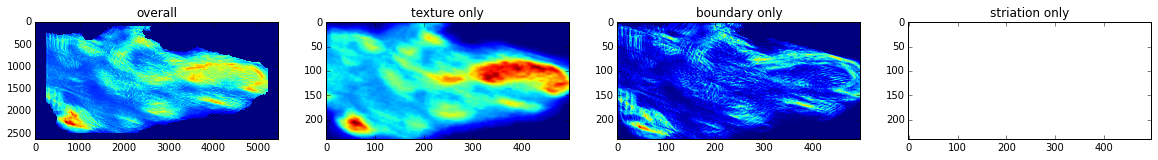

In [32]:
fig, axes = plt.subplots(1,4, figsize=(20,20))
axes[0].imshow(vs_max_all_angles[4]);
axes[0].set_title('overall');
axes[1].imshow(vs_texture_all_angles[4]);
axes[1].set_title('texture only');
axes[2].imshow(vs_boundary_all_angles[4]);
axes[2].set_title('boundary only');
axes[3].imshow(vs_striation_all_angles[4]);
axes[3].set_title('striation only');
# axes[3].imshow(Gmax);
# axes[3].set_title('edge prob. map');